In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

C:\Users\vardh\AppData\Roaming\Python\Python310\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
seed = 42

In [3]:
from datasets import load_dataset
# Load the dataset
dataset = load_dataset("keivalya/MedQuad-MedicalQnADataset")
train = dataset['train']
train_df = pd.DataFrame(train)

In [4]:
# Remove unwanted labels
labels_to_remove = ['support groups', 'complications', 'stages']
train_df = train_df[~train_df['qtype'].isin(labels_to_remove)]

In [5]:
display(train_df.head())
display(train_df.shape)

,qtype,Question,Answer
0,susceptibility,Who is at risk for Lymphocytic Choriomeningiti...,LCMV infections can occur after exposure to fr...
1,symptoms,What are the symptoms of Lymphocytic Choriomen...,LCMV is most commonly recognized as causing ne...
2,susceptibility,Who is at risk for Lymphocytic Choriomeningiti...,Individuals of all ages who come into contact ...
3,exams and tests,How to diagnose Lymphocytic Choriomeningitis (...,"During the first phase of the disease, the mos..."
4,treatment,What are the treatments for Lymphocytic Chorio...,"Aseptic meningitis, encephalitis, or meningoen..."


(16283, 3)

In [6]:
# Split the dataset into train and test sets
train_df, test_df = train_test_split(train_df, test_size=0.3, random_state=seed)

In [7]:
display(train_df.shape)
display(test_df.shape)

(11398, 3)

(4885, 3)

In [8]:
# Encode the labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_df['labels'] = label_encoder.fit_transform(train_df['qtype'])

In [9]:
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Encoding Mapping:")
for original_label, encoded_label in label_mapping.items():
    print(f"{original_label}: {encoded_label}")

Label Encoding Mapping:
causes: 0
considerations: 1
exams and tests: 2
frequency: 3
genetic changes: 4
information: 5
inheritance: 6
outlook: 7
prevention: 8
research: 9
susceptibility: 10
symptoms: 11
treatment: 12


In [10]:
# Tokenizer and model from transformers
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification, get_linear_schedule_with_warmup, AdamW

In [11]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token

In [12]:
def tokenize_texts_new(texts, batch_size=8):
    input_ids_list = []
    attention_mask_list = []
    
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors='pt', truncation=True, padding=True, max_length=512)
        
        input_ids_list.append(inputs['input_ids'])
        attention_mask_list.append(inputs['attention_mask'])
    
    # Ensure consistent size for concatenation
    max_length = 512
    
    for i in range(len(input_ids_list)):
        if input_ids_list[i].size(1) != max_length:
            padding_size = max_length - input_ids_list[i].size(1)
            input_ids_list[i] = torch.nn.functional.pad(input_ids_list[i], (0, padding_size), value=tokenizer.pad_token_id)
            attention_mask_list[i] = torch.nn.functional.pad(attention_mask_list[i], (0, padding_size), value=0)
    
    input_ids = torch.cat(input_ids_list, dim=0)
    attention_masks = torch.cat(attention_mask_list, dim=0)
    
    return input_ids, attention_masks

In [13]:
# Tokenize the texts in the training dataset
texts = train_df['Question'].tolist()
input_ids, attention_masks = tokenize_texts_new(texts)

In [14]:
# Convert labels to PyTorch tensor
labels = torch.tensor(train_df['labels'].tolist())

In [15]:
# Split the dataset into train and vaLidation sets
input_ids_train, input_ids_val, attention_masks_train, attention_masks_val, labels_train, labels_val = train_test_split(
    input_ids, attention_masks, labels, test_size=0.3, random_state=seed)

In [16]:
display(input_ids_train.shape)
display(input_ids_val.shape)

torch.Size([7978, 512])

torch.Size([3420, 512])

In [23]:
# Load the pre-trained GPT-2 model for sequence classification
model = GPT2ForSequenceClassification.from_pretrained('gpt2', num_labels=13)
model.config.pad_token_id = tokenizer.pad_token_id  # Set pad_token_id in model config|

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
# Freeze all layers except the last two
for name, param in model.named_parameters():
    if 'transformer.h.10' in name or 'transformer.h.11' in name or 'score' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

In [25]:
# Define optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
total_steps = (len(input_ids_train) // 16) * 3  # Assuming 3 epochs and batch size of 16
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

In [26]:
# Training function
def train(model, input_ids_train, attention_masks_train, labels_train, optimizer, scheduler, device, batch_size=16):
    model.train()
    total_loss = 0
    for i in range(0, len(input_ids_train), batch_size):
        batch_input_ids = input_ids_train[i:i+batch_size].to(device)
        batch_attention_masks = attention_masks_train[i:i+batch_size].to(device)
        batch_labels = labels_train[i:i+batch_size].to(device)
        
        model.zero_grad()
        outputs = model(batch_input_ids, attention_mask=batch_attention_masks, labels=batch_labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()
        print(f"Batch {i}, Train loss: {loss.item():.4f}")
    return total_loss / (len(input_ids_train) // batch_size)

In [27]:
# Main training loop
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (score): Linear(in_features=768, out_features=13, bias=False)
)

In [28]:
epochs = 3
for epoch in range(epochs):
    print('\n\nTraining Epoch', epoch)
    train_loss = train(model, input_ids_train, attention_masks_train, labels_train, optimizer, scheduler, device)
    print(f"Epoch {epoch + 1}, Train loss: {train_loss:.4f}")



Training Epoch 0
Batch 0, Train loss: 6.5703
Batch 16, Train loss: 6.0817
Batch 32, Train loss: 7.6969
Batch 48, Train loss: 6.2711
Batch 64, Train loss: 7.6830
Batch 80, Train loss: 6.3684
Batch 96, Train loss: 5.6048
Batch 112, Train loss: 4.5678
Batch 128, Train loss: 7.1510
Batch 144, Train loss: 6.2612
Batch 160, Train loss: 5.8264
Batch 176, Train loss: 5.9884
Batch 192, Train loss: 5.6831
Batch 208, Train loss: 6.2483
Batch 224, Train loss: 4.7288
Batch 240, Train loss: 6.4974
Batch 256, Train loss: 5.3014
Batch 272, Train loss: 3.8798
Batch 288, Train loss: 4.4010
Batch 304, Train loss: 4.5290
Batch 320, Train loss: 4.1379
Batch 336, Train loss: 3.5524
Batch 352, Train loss: 5.5563
Batch 368, Train loss: 4.5064
Batch 384, Train loss: 2.9427
Batch 400, Train loss: 4.1318
Batch 416, Train loss: 4.4139
Batch 432, Train loss: 4.3538
Batch 448, Train loss: 3.3714
Batch 464, Train loss: 4.1014
Batch 480, Train loss: 4.6335
Batch 496, Train loss: 4.1520
Batch 512, Train loss: 3.7149

Batch 4256, Train loss: 0.9494
Batch 4272, Train loss: 0.8269
Batch 4288, Train loss: 1.5658
Batch 4304, Train loss: 0.8728
Batch 4320, Train loss: 1.1346
Batch 4336, Train loss: 1.1359
Batch 4352, Train loss: 2.0063
Batch 4368, Train loss: 0.9223
Batch 4384, Train loss: 0.7168
Batch 4400, Train loss: 1.4094
Batch 4416, Train loss: 0.6382
Batch 4432, Train loss: 1.6046
Batch 4448, Train loss: 0.5969
Batch 4464, Train loss: 0.7587
Batch 4480, Train loss: 0.5464
Batch 4496, Train loss: 0.9247
Batch 4512, Train loss: 0.8812
Batch 4528, Train loss: 0.8018
Batch 4544, Train loss: 0.9296
Batch 4560, Train loss: 0.3581
Batch 4576, Train loss: 1.0947
Batch 4592, Train loss: 1.1762
Batch 4608, Train loss: 1.0354
Batch 4624, Train loss: 0.6093
Batch 4640, Train loss: 1.1658
Batch 4656, Train loss: 0.9393
Batch 4672, Train loss: 0.9243
Batch 4688, Train loss: 0.8171
Batch 4704, Train loss: 0.9632
Batch 4720, Train loss: 0.7974
Batch 4736, Train loss: 0.5979
Batch 4752, Train loss: 1.0380
Batch 47

Batch 512, Train loss: 0.0578
Batch 528, Train loss: 0.0392
Batch 544, Train loss: 0.0694
Batch 560, Train loss: 0.0437
Batch 576, Train loss: 0.0502
Batch 592, Train loss: 0.1608
Batch 608, Train loss: 0.0947
Batch 624, Train loss: 0.1572
Batch 640, Train loss: 0.0611
Batch 656, Train loss: 0.0318
Batch 672, Train loss: 0.1629
Batch 688, Train loss: 0.2076
Batch 704, Train loss: 0.4661
Batch 720, Train loss: 0.0409
Batch 736, Train loss: 0.1817
Batch 752, Train loss: 0.3677
Batch 768, Train loss: 0.4056
Batch 784, Train loss: 0.1827
Batch 800, Train loss: 0.1061
Batch 816, Train loss: 0.3262
Batch 832, Train loss: 0.0299
Batch 848, Train loss: 0.0296
Batch 864, Train loss: 0.1146
Batch 880, Train loss: 0.0590
Batch 896, Train loss: 0.0225
Batch 912, Train loss: 0.2722
Batch 928, Train loss: 0.0814
Batch 944, Train loss: 0.1206
Batch 960, Train loss: 0.0807
Batch 976, Train loss: 0.0118
Batch 992, Train loss: 0.2884
Batch 1008, Train loss: 0.1287
Batch 1024, Train loss: 0.1041
Batch 10

Batch 4768, Train loss: 0.0110
Batch 4784, Train loss: 0.4034
Batch 4800, Train loss: 0.0229
Batch 4816, Train loss: 0.0171
Batch 4832, Train loss: 0.0328
Batch 4848, Train loss: 0.0862
Batch 4864, Train loss: 0.0269
Batch 4880, Train loss: 0.0778
Batch 4896, Train loss: 0.0141
Batch 4912, Train loss: 0.0250
Batch 4928, Train loss: 0.0640
Batch 4944, Train loss: 0.0193
Batch 4960, Train loss: 0.0095
Batch 4976, Train loss: 0.0305
Batch 4992, Train loss: 0.0575
Batch 5008, Train loss: 0.0323
Batch 5024, Train loss: 0.0744
Batch 5040, Train loss: 0.0184
Batch 5056, Train loss: 0.0149
Batch 5072, Train loss: 0.0198
Batch 5088, Train loss: 0.0237
Batch 5104, Train loss: 0.0108
Batch 5120, Train loss: 0.0191
Batch 5136, Train loss: 0.0343
Batch 5152, Train loss: 0.0103
Batch 5168, Train loss: 0.0152
Batch 5184, Train loss: 0.0737
Batch 5200, Train loss: 0.1541
Batch 5216, Train loss: 0.0449
Batch 5232, Train loss: 0.0519
Batch 5248, Train loss: 0.0240
Batch 5264, Train loss: 0.0071
Batch 52

Batch 1040, Train loss: 0.1032
Batch 1056, Train loss: 0.0236
Batch 1072, Train loss: 0.0246
Batch 1088, Train loss: 0.0212
Batch 1104, Train loss: 0.0156
Batch 1120, Train loss: 0.1000
Batch 1136, Train loss: 0.0255
Batch 1152, Train loss: 0.0303
Batch 1168, Train loss: 0.0276
Batch 1184, Train loss: 0.0251
Batch 1200, Train loss: 0.0125
Batch 1216, Train loss: 0.0246
Batch 1232, Train loss: 0.0448
Batch 1248, Train loss: 0.0278
Batch 1264, Train loss: 0.0060
Batch 1280, Train loss: 0.0125
Batch 1296, Train loss: 0.0970
Batch 1312, Train loss: 0.0466
Batch 1328, Train loss: 0.0193
Batch 1344, Train loss: 0.0250
Batch 1360, Train loss: 0.0306
Batch 1376, Train loss: 0.0454
Batch 1392, Train loss: 0.0081
Batch 1408, Train loss: 0.0185
Batch 1424, Train loss: 0.0444
Batch 1440, Train loss: 0.0168
Batch 1456, Train loss: 0.0419
Batch 1472, Train loss: 0.0134
Batch 1488, Train loss: 0.2219
Batch 1504, Train loss: 0.0233
Batch 1520, Train loss: 0.0466
Batch 1536, Train loss: 0.0382
Batch 15

Batch 5280, Train loss: 0.0152
Batch 5296, Train loss: 0.0048
Batch 5312, Train loss: 0.0135
Batch 5328, Train loss: 0.1174
Batch 5344, Train loss: 0.0358
Batch 5360, Train loss: 0.0017
Batch 5376, Train loss: 0.0165
Batch 5392, Train loss: 0.0053
Batch 5408, Train loss: 0.0073
Batch 5424, Train loss: 0.0083
Batch 5440, Train loss: 0.0088
Batch 5456, Train loss: 0.0125
Batch 5472, Train loss: 0.0081
Batch 5488, Train loss: 0.0098
Batch 5504, Train loss: 0.0078
Batch 5520, Train loss: 0.0091
Batch 5536, Train loss: 0.0127
Batch 5552, Train loss: 0.0109
Batch 5568, Train loss: 0.0080
Batch 5584, Train loss: 0.0083
Batch 5600, Train loss: 0.0043
Batch 5616, Train loss: 0.0174
Batch 5632, Train loss: 0.0111
Batch 5648, Train loss: 0.0210
Batch 5664, Train loss: 0.0182
Batch 5680, Train loss: 0.0042
Batch 5696, Train loss: 0.0425
Batch 5712, Train loss: 0.0096
Batch 5728, Train loss: 0.1065
Batch 5744, Train loss: 0.0214
Batch 5760, Train loss: 0.0081
Batch 5776, Train loss: 0.0684
Batch 57

In [33]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [34]:
# Evaluation function
def evaluate(model, input_ids_test, attention_masks_test, labels_test, device, batch_size=8):
    model.eval()
    preds, true_labels = [], []
    with torch.no_grad():
        for i in range(0, len(input_ids_test), batch_size):
            batch_input_ids = input_ids_test[i:i+batch_size].to(device)
            batch_attention_masks = attention_masks_test[i:i+batch_size].to(device)
            batch_labels = labels_test[i:i+batch_size].to(device)
            
            outputs = model(batch_input_ids, attention_mask=batch_attention_masks)
            logits = outputs.logits
            preds.append(logits.argmax(dim=1).cpu().numpy())
            true_labels.append(batch_labels.cpu().numpy())
    preds = np.concatenate(preds)
    true_labels = np.concatenate(true_labels)
    accuracy = accuracy_score(true_labels, preds)
    f1 = f1_score(true_labels, preds, average='weighted')
    precision = precision_score(true_labels, preds, average='weighted')
    recall = recall_score(true_labels, preds, average='weighted')
    return accuracy, f1, precision, recall, preds

In [36]:
# Evaluate the model
accuracy_val, f1_val, precision_val, recall_val, preds_val = evaluate(model, input_ids_val, attention_masks_val, labels_val, device)
print(f"Accuracy: {accuracy_val:.4f}")
print(f"F1 Score: {f1_val:.4f}")
print(f"Precision: {precision_val:.4f}")
print(f"Recall: {recall_val:.4f}")

Accuracy: 0.9974
F1 Score: 0.9974
Precision: 0.9974
Recall: 0.9974


In [38]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

<Figure size 3000x3000 with 0 Axes>

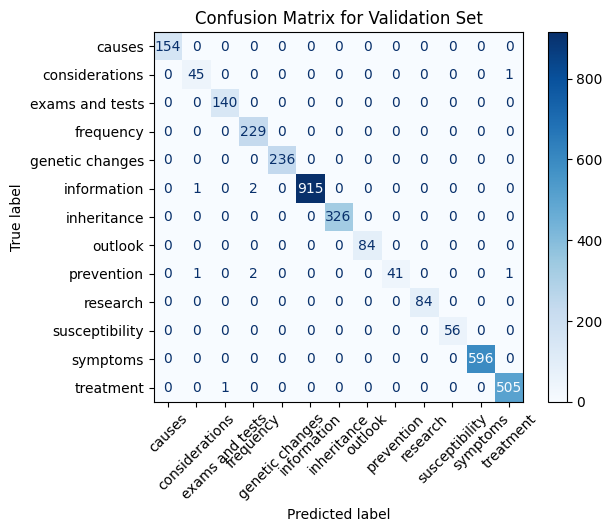

In [40]:
# Calculate the confusion matrix
cm = confusion_matrix(labels_val, preds_val)

# Create a larger figure for better readability
plt.figure(figsize=(30,30))

# Display the confusion matrix with tilted x-tick labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)

plt.title('Confusion Matrix for Validation Set')
plt.show()

In [42]:
# Encode labels for the test set
test_df['labels'] = label_encoder.transform(test_df['qtype'])

In [43]:
# Tokenize the texts in the test set
test_texts = test_df['Question'].tolist()
test_input_ids, test_attention_masks = tokenize_texts_new(test_texts)
test_labels = torch.tensor(test_df['labels'].tolist())

In [44]:
# Evaluate on the test set
print("Evaluating on the test set...")
test_accuracy, test_f1, test_precision, test_recall, test_preds = evaluate(
    model, test_input_ids, test_attention_masks, test_labels, device)

Evaluating on the test set...


In [45]:
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")

Test Accuracy: 0.9977
Test F1 Score: 0.9977
Test Precision: 0.9978
Test Recall: 0.9977


<Figure size 3000x3000 with 0 Axes>

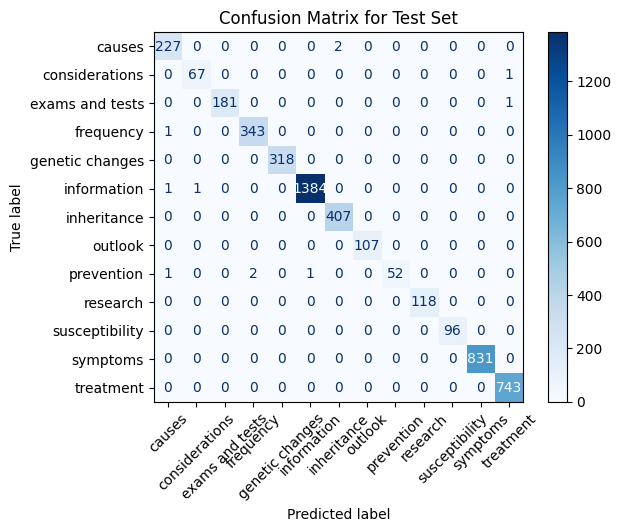

In [46]:
# Calculate the confusion matrix for the test set
cm = confusion_matrix(test_labels, test_preds)

# Create a larger figure for better readability
plt.figure(figsize=(30,30))

# Display the confusion matrix with tilted x-tick labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)

plt.title('Confusion Matrix for Test Set')
plt.show()